# Fill in outs 
## June

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os


from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'


## We don't know now many outs there are at any point!

In [ ]:
bf_1903_30 = Baseball_Field("1903_30_TeamNB_TeamA1")
game_info_1903_30 = bf_1903_30.game_obj.game_info_df.copy()

## ~~Lean full into the Sudoku solver strategy~~ This is in Game now!


At a high level, I think I need:
- a recursive function that returns true or false
    - a for loop from 0, 2 (inclusive)
- a thing that finds an empty cell
- an "is_valid_outs" function where I enumerate all of my rules


### I think I want to keep the half inning df, but pass around the sequences!

In [ ]:
def get_play_id_and_ppg_for_event(game_obj, event, **kwargs):
    """
    takes in a game_events_df
    
    event is "home run", etc
    
    """
    event_indices = game_obj.game_events_df["event"] == event
    
    if len(kwargs) != 0:
        
        for k,v in kwargs.items():
                        
            if type(v) is list:                
                event_indices = (event_indices) & (game_obj.game_events_df[k].isin(v))
                
            else:
                event_indices = (event_indices) & (game_obj.game_events_df[k] == v)
            
    return game_obj.game_events_df.loc[event_indices, ["play_id", "play_per_game"]].drop_duplicates()
    
    

# get_play_id_and_ppg_for_event(bf_1903_30.game_obj, "home run")


get_play_id_and_ppg_for_event(bf_1903_30.game_obj, "ball acquired", player_position=[7, 8, 9], next_event="end of play")



In [ ]:
def solve_outs_sequence_seq(game_obj, half_inning_df, seq):
    
    empty_cell_index = find_empty_cell_seq(seq)
    
    if empty_cell_index is None:
        # you have found a valid solution and this is what makes your thing return
        return True
    
    
    for this_play_outs in range(3):
        
        if is_valid_outs_assignment_seq(game_obj, half_inning_df, seq, this_play_outs, empty_cell_index):
            seq[empty_cell_index, 1] = this_play_outs
            
            temp_sum = 0 if empty_cell_index == 0 else sum(seq[empty_cell_index - 1, :])
            
            seq[empty_cell_index, 0] = temp_sum
            
            pass
            
            
            if solve_outs_sequence_seq(game_obj, half_inning_df, seq):
                # you did it!
                return True
        
            seq[empty_cell_index, 0] = np.nan
            seq[empty_cell_index, 1] = np.nan
            
    return False


def find_empty_cell_seq(seq):
        
    index = None
    
    # this play outs is in the second column!
    
    for i, val in enumerate(seq[:, 1]):
        if np.isnan(val):
            return i
    
    return index


def is_valid_outs_assignment_seq(game_obj, half_inning_df, seq, this_play_outs, empty_cell_index):
    
    all_batting_team = ["batter", "first_baserunner", "second_baserunner", "third_baserunner"]
    all_br = ["first_baserunner", "second_baserunner", "third_baserunner"]
    
    seq_len = seq.shape[0]
    
    # debugging
    
    this_row = half_inning_df.iloc[empty_cell_index]
    
    old_set_batting_team = set()
    prev_total_outs = 0
    
    if empty_cell_index != 0:
        # you need to set and check all of the things that look at the prev row 
        old_set_batting_team = set(half_inning_df.iloc[empty_cell_index - 1][all_batting_team])
        prev_total_outs = sum(seq[empty_cell_index - 1, :])
          
    next_batter = None
    next_set_batting_team = set()
    next_set_br = set()
    next_second_br = None
    next_third_br = None
    

    hr_play_per_games = get_play_id_and_ppg_for_event(game_obj, "home run")["play_per_game"].values

    flyouts_that_end_play = get_play_id_and_ppg_for_event(game_obj,
                                                          "ball acquired", 
                                                          player_position=[7, 8, 9],
                                                          next_event="end of play")["play_per_game"].values

    

    if empty_cell_index < seq_len - 1:
        next_batter = half_inning_df.iloc[empty_cell_index + 1]["batter"]
        next_set_batting_team = set(half_inning_df.iloc[empty_cell_index + 1][all_batting_team])
        next_set_br = set(half_inning_df.iloc[empty_cell_index + 1][all_br])
        
        next_second_br = half_inning_df.iloc[empty_cell_index + 1]["second_baserunner"]
        next_third_br = half_inning_df.iloc[empty_cell_index + 1]["third_baserunner"]
    
    this_batter = half_inning_df.iloc[empty_cell_index]["batter"]
    this_set_br = set(half_inning_df.iloc[empty_cell_index][all_br])
    this_first_br = half_inning_df.iloc[empty_cell_index]["first_baserunner"]
    this_second_br = half_inning_df.iloc[empty_cell_index]["second_baserunner"]
    this_third_br = half_inning_df.iloc[empty_cell_index]["third_baserunner"]
    
    
    
    same_batter_next_play = this_batter == next_batter
    
    # Outs has to be the same or more as all previous indices in the sequence
    this_set_batting_team = set(half_inning_df.iloc[empty_cell_index][all_batting_team])
        
    
    does_this_make_3 = prev_total_outs + this_play_outs
    
    this_play_per_game = half_inning_df.iloc[empty_cell_index]["play_per_game"]
    
    # hr_play_per_games = bf_1903_30.game_obj.game_events_df.loc[hr_indices, "play_per_game"].values
    
    ## end debugging
    
    pass
    
    # Assuming consecutive indices!

    
    # TODO: 
    # It can't be an out if the batter is on base next play and a runner scores
    


    if this_play_outs != 0 and this_play_per_game \
        in hr_play_per_games:
        # Outs can't go up on a home run
        return False

    if this_play_outs == 0 and this_batter not in next_set_br \
        and this_batter != next_batter and this_play_per_game not in hr_play_per_games:
        # if the batter is not on the bases when there is a new batter and it wasn't a HR then the batter got out:
    
        return False
    
    
    if this_play_outs > 1 and this_play_per_game in flyouts_that_end_play:
    # if the last thing that happens is a ball being acquired by an outfield, then there can't be more than 1 out on the play
    # this will fail if the outfielders get into a run down and tag someone out for a double play, but that seems super rare
        return False
    
    
    if this_play_outs == 0 and this_batter != next_batter and this_play_per_game not in hr_play_per_games and \
        this_batter in next_set_br and this_first_br not in next_set_br and this_first_br != 0 and \
            ((this_second_br in next_set_br and this_second_br != 0) or (this_third_br in next_set_br and this_third_br != 0)):
        # Outs must go up if there is a runner this isn't on the bases on the next play, and there are were runners ahead of them on this play
        
        # Fielders choice out at second
        
        return False
     
        
    """
     if this_play_outs == 0 and this_batter != next_batter and this_play_per_game not in hr_play_per_games and \
        this_batter in next_set_br and this_second_br not in next_set_br  and this_third_br in next_set_br and this_third_br != "0"):
        
        # Fielders choice out at third
        
        return False
    """
         
    # TODO: Fielders choice out at home??
        
    
        
    if this_play_outs != 1 and set([br for br in this_set_br if br != 0 ]) == set([br for br in next_set_br if br != 0 ]) \
        and this_batter != next_batter:
        # TODO:
        # It must be 1 out if there are non zero BRs that stay the same, and there is a new batter -- this is a strikeout
        # Assumption this goes wrong for mid at bat PH, but that might be rare -- ignore that
        
        return False
    
    
    if this_play_outs != 0 and this_set_batting_team == next_set_batting_team:
    # Outs can't go up is there is the same batter and baserunners
        return False
    
    
    if this_play_outs > (1 + half_inning_df.iloc[empty_cell_index]["n_br"]):
        # Outs can't go up by more than the number of baserunners + 1
        return False
    
    if this_play_outs != 0 \
        and next_set_br == this_set_batting_team:
        # and half_inning_df.iloc[empty_cell_index - 1]["batter"] != 0\ # not sure about this part
        
            # Outs can't go up if the batter becomes the baserunner on the next play 
            # and the previous set of baserunners is still there

            return False
    
    
    if this_play_outs != 0 and len(this_set_batting_team) == 2 and same_batter_next_play:
        # Outs can't go up if there are no baserunners and the batter is the same in the next play
        # len(this_set_batting_team) == 2 is because the set will be batter_num and 0
    
        return False
        
    
    
    if ((seq_len - 1) == (empty_cell_index)) \
        and (does_this_make_3 != 3):
        # if we are on the last index, then this_play_outs and prev_outs must sum to three
        
        return False

    
    
    
    return True



    
    

#### Test case on an obviously 1-2-3 inning

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 1) & (game_info_1903_30["top_bottom_inning"] == "Top")]

### Bottom of the first
#### this one seems harder, because there are baserunners, etc

- if something is wrong on this, I think the plan will be to check things like throws and balls acquired, etc


In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 1) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

##### Description of bottom of the first

Brainstorming on how where this is wrong, and what could be done to make it work better
- I think "baserunner scores" could be something?

A description of what is going on rn:

- 20 is an advancement on a passed ball or wild pitch
- 22 is a single that moves the runner to single I think -- its actually a fielding error lol
- 27 is another advancement on a passed ball or wild pitch
- 29 is this an RBI ground out that gets called safe?

- 34 is a single to right, with the runner on third scoring
- 39 is a walk or right?
- 43 is another walk? it was wayyyy outside lol
- 46 should have been a strikeout I think? --- COME UP WITH A STRIKEOUT RULE? Maybe if there is a new batter, and all the br stay the same -- this goes wrong for mid at bat PH, but that might be rare -- 
- 51 is a walk that gets marked a strikeout -- FIX HERE -- It can't be an out if that batter it on base next play
- 56 is a flyout to center field, -- FIX HERE -- it is only one out! 

In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(56)

bf_1903_30.plot_all_components(play_id=play_id)

bf_1903_30.fig
# bf_1903_30.create_gif(play_id=play_id, tag="--is this a dp")

### Top of the second

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 2) & (game_info_1903_30["top_bottom_inning"] == "Top")]

##### Top of second description

A description of what is going on rn:

- 62 was a 4-3 put out
- 65 is a 6-3 put out
- 69 is a dropped third strike lol
- 75 is 6 unassisted

In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(75)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--6_unassisted")

### Bottom of the second

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 2) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

##### Bottom of second description

A description of what is going on rn:

- 76 is a HBP lol that it counts as a ball deflection
- 78 is a double to left field
- 79 is a triple off the right center wall
- 83 is a walk
- 85 is a sac fly to center
- 87 is a 1-3 sacrifice?
- 90 is a lazy fly to left



In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(85)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")

### Top of 3

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 3) & (game_info_1903_30["top_bottom_inning"] == "Top")]

#### Where should there be outs:
- 94 must be an out (strikeout)
- what happened on 95? This is a throwing error -- there should not be an out
- 97 (we don't know?) because it isn't there (but one out?)
- 108 is a play at the plate I think no outs
- 109 is a 5-3 put out

In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(109)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom 3

This is a 1-2-3 inning

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 3) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

### Top 4

A 1-2-3 inning

- 122 is a flyout
- 128 is a flyout
- 131 is a flyout

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 4) & (game_info_1903_30["top_bottom_inning"] == "Top")]

In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(131)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom 4

- 132 is popup to short
- 134 is a flyout
- 137 is a flyout

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 4) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(137)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Top 5

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 5) & (game_info_1903_30["top_bottom_inning"] == "Top")]

Another 1-2-3

- 138 is 1-3 ground out
- 142 is another 1-3 ground out
- 144 5-3 ground out

In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(144)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom 5

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 5) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

#### Where should there be outs:

- 154 could be an out if its a play at the plate -- I think this is not an out
- 159 is a flyout
- 160 is a fielder's choice, where the running beats the throw that would have turned two
- 165 is a 6-4 put out


In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(165)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Top 6 -- its says don't trust, but this one is fine

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 6) & (game_info_1903_30["top_bottom_inning"] == "Top")]

#### Where should there be outs:

- 171 is a popup
- 176 is proabably a wild pitch and a score -- lol
- 178 is a RBI sacrifice of some kind (6-3 RBI groundout)
- 182 is a strikeout


In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(178)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom of 6 -- Something is missing, don't trust this one


In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 6) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

#### Where should there be outs:


- 187 is a steal?

- TODO: Bring this one up!!! 
    - 198 looks just like a pitch catch? but the third br disappears?
    
- 200 is a strikeout
- 202 is just a flyout -- maybe make a new rule for this one? (e.g. fly ball rule!)



In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(202)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Top 7

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 7) & (game_info_1903_30["top_bottom_inning"] == "Top")]

#### This is a 1-2-3 inning
- 206 is dropped third 2-3 putout
- 211 is a popup to 5
- 215 must be a strikeout


In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(215)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Bottom 7

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 7) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

#### This is a 1-2-3 inning

- 219 a 5-3 putout
- 223 a strikeout
- 227 a 4-3 putout

In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(227)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--scores on a hit to left")

### Top of 8 works now

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 8) & (game_info_1903_30["top_bottom_inning"] == "Top")]

#### Where should there be outs:

- 234 is 4-3, runner advances
- 236 should be HR
- 249 is a strikeout
- 256 must be another strikeout



In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(256)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")


### Bottom 8

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 8) & (game_info_1903_30["top_bottom_inning"] == "Bottom")]

#### A 1-2-3 inning

- 260 a bobble, 4-3 putout
- 263 flyout to 9
- 267 strikout

In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(267)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")


### Top 9

In [ ]:
game_info_1903_30.loc[(game_info_1903_30["inning"] == 9) & (game_info_1903_30["top_bottom_inning"] == "Top")]

#### A 1-2-3 inning

- 271 a 5-3 putout
- 275 flyout to 8
- 276 a 4-3 putout

In [ ]:
bf_1903_30.clear_plot()

play_id = bf_1903_30.game_obj.get_pid_from_ppg(276)

bf_1903_30.plot_all_components(play_id=play_id)
bf_1903_30.fig

# bf_1903_30.create_gif(play_id=play_id, tag="--lazy fly to left")


## Gut Checks



In [ ]:
# there should never be more than 3 outs in either column
game_info_1903_30[["prev_outs", "this_play_outs"]].describe()

### Are all of the things that have two outs obvious double plays?

In [ ]:
game_info_1903_30.loc[game_info_1903_30["this_play_outs"] == 2, :]

### OTHER CHECKS HERE?





## Try again for a different game: 

In [ ]:
bf_1900_01 = Baseball_Field("1900_01_TeamKJ_TeamB")
game_info_1900_01 = bf_1900_01.game_obj.game_info_df.copy()

In [ ]:
game_info_1900_01.loc[(game_info_1900_01["inning"] == 1) & (game_info_1900_01["top_bottom_inning"] == "Top")]

In [ ]:
game_info_1900_01.loc[(game_info_1900_01["this_play_outs"] == 1) & (game_info_1900_01["trust_this_half"] == 1)]

#### Where I am confident there are outs
- 93 is a 2-3 putout
- 96 is a strikeout
- 100 flyout to 8
- 104 strikeout?
- 107 strikeout?
- 192 strikeout
- 198 strikeout
- 202 strikeout
- 236 strikeout
- 239 strikeout
- 243 6-3 putout
- 249 strikeout
- 255 strikeout
- 256 IDK on this out? maybe a tip into the glove?

#### Where I am less sure, but there might be outs there are outs

- 4
- 64
- 78 flyout
- 82
- 85
- 111 flyout
- 125
- 127
- 129
- 133
- 142
- 145
- 155
- 160
- 174
- 182
- 189
- 206
- 210
- 216
- 222
- 258
- 264 flyout
- 267
- 268
- 269
- 270 popout to second

In [ ]:
game_info_1900_01.loc[(game_info_1900_01["this_play_outs"] == 1) & (game_info_1900_01["valid_half"] == 1) & (game_info_1900_01["trust_this_half"] == 0) ]

In [ ]:
bf_1900_01.clear_plot()

play_id = bf_1900_01.game_obj.get_pid_from_ppg(270)

bf_1900_01.plot_all_components(play_id=play_id)
bf_1900_01.fig

# bf_1900_01.create_gif(play_id=play_id, tag="--lazy fly to left")


In [ ]:
bf_1900_01.game_obj.game_events_df.loc[bf_1900_01.game_obj.game_events_df["event"] == "home run"] 

#### Weird missing baserunners in this game 1900_01_TeamKJ_TeamB
- 14, 15, 16 are missing the lead baserunner in game info
- I think there is something weird with the data here! the last play of the top half of the second is a HR
    - its play 52

- This game is all messed up! Idk that I want to deal with this tbh 
- I think just skip these half innings!


In [ ]:
game_info_1900_01.loc[(game_info_1900_01["inning"] == 1) & (game_info_1900_01["top_bottom_inning"] == "Bottom")]

In [ ]:
bf_1900_01.clear_plot()

play_id = bf_1900_01.game_obj.get_pid_from_ppg(39)

bf_1900_01.plot_all_components(play_id=play_id)
bf_1900_01.fig

# bf_1900_01.create_gif(play_id=play_id, tag="--7-6-5-1")


## Try a new game! 1903_13_TeamNG_TeamA3

In [ ]:
bf_1903_13 = Baseball_Field("1903_13_TeamNG_TeamA3")

game_info_1903_13 = bf_1903_13.game_obj.game_info_df.copy()

In [ ]:
game_info_1903_13.loc[(game_info_1903_13["this_play_outs"] >= 1) & (game_info_1903_13["trust_this_half"] == 1)]

In [ ]:
game_info_1903_13.loc[(game_info_1903_13["this_play_outs"] > 1) & (game_info_1903_13["trust_this_half"] == 1)]

In [ ]:

bf_1903_13.clear_plot()

play_id = bf_1903_13.game_obj.get_pid_from_ppg(236)

bf_1903_13.plot_all_components(play_id=play_id)
bf_1903_13.fig


# bf_1903_13.create_gif(play_id=play_id, tag="--6-4-3_DP")


#### I think the whole game for bf_1903_13 works!

## Spot check: 1903_17_TeamNI_TeamA3

In [ ]:
bf_1903_17 = Baseball_Field("1903_17_TeamNI_TeamA3")

game_info_1903_17 = bf_1903_17.game_obj.game_info_df.copy()

In [ ]:
game_info_1903_17.loc[(game_info_1903_17["this_play_outs"] == 1) & (game_info_1903_17["trust_this_half"] == 1)]

#### Weird missing baserunners in this game 1903_17_TeamNI_TeamA3
- there are two play_per_game 3s here (I wonder if I just remove, if that goes away?)
- Bottom of 1 is missing some plays for sure!
- Top of 4 is literally 1 play, which messes up the -99 assignment
- there is also some duplicate play_per_games here 187




In [ ]:
game_info_1903_17.loc[(game_info_1903_17["this_play_outs"] > 1) & (game_info_1903_17["trust_this_half"] == 1)]

#### Ugh there must be missing plays in the sequence because 173 is clearly not a DP

In [ ]:

bf_1903_17.clear_plot()

play_id = bf_1903_17.game_obj.get_pid_from_ppg(193)

bf_1903_17.plot_all_components(play_id=play_id)
bf_1903_17.fig


# bf_1903_17.create_gif(play_id=play_id, tag="--2-3 bunt")


#### A curiousity for later -- throws to first where the batter is safe?

In [ ]:
g_1903_17_events = bf_1903_17.game_obj.game_events_df.copy()

g_1903_17_events.loc[(g_1903_17_events["event"] == "ball acquired") & (g_1903_17_events["player_position"] == 3) &\
                     (g_1903_17_events["prev_event"] != "pickoff throw") &\
                     g_1903_17_events["play_per_game"].isin(game_info_1903_17.loc[game_info_1903_17["this_play_outs"] == 0, "play_per_game"].values)
                     ,
                     :
                    ]

In [ ]:
bf_1903_17.clear_plot()

play_id = bf_1903_17.game_obj.get_pid_from_ppg(164)

bf_1903_17.plot_all_components(play_id=play_id)
bf_1903_17.fig

## Spot check: 1902_24_TeamMA_TeamA1

In [ ]:
bf_1902_24 = Baseball_Field("1902_24_TeamMA_TeamA1")

In [ ]:
game_info_1902_24 = bf_1902_24.game_obj.game_info_df.copy()

In [ ]:
game_info_1902_24.loc[(game_info_1902_24["this_play_outs"] > 0) & (game_info_1902_24["trust_this_half"] == 1), :]

In [ ]:
this_half_df = game_info_1902_24.loc[(game_info_1902_24["inning"] == 7) & (game_info_1902_24["top_bottom_inning"] == "Bottom"), :]
this_half_df

#### Weird things in this game 1902_24_TeamMA_TeamA1
- 267 looks like an out to me, why is the batter still there on the next play?
- I think this at_bat field is wrong? 
- 141 is a ball in play, but then that batter is there for the next several plays?

- SOMETHING IS NOT RIGHT FOR THIS ONE!! I think either the plays are mislabelled or I am seeing a new case I didn't consider?

- I think there are missing BRs!!! like the 242 sequence is wrong?

- 253 doesn't have runners on even?




In [ ]:
g_1902_24_events = bf_1902_24.game_obj.game_events_df.copy()

# I should use that function I wrote here!

g_1902_24_events.loc[(g_1902_24_events["event"] == "ball acquired") & (g_1902_24_events["player_position"] == 3) &\
                     (g_1902_24_events["prev_event"] != "pickoff throw") &\
                     g_1902_24_events["play_per_game"].isin(game_info_1902_24.loc[game_info_1902_24["this_play_outs"] == 0, "play_per_game"].values)
                     ,
                     :
                    ]

#### Where was there an out that ended with the first baseman catching the ball

In [ ]:
g_1902_24_events = bf_1902_24.game_obj.game_events_df.copy()

# I should use that function I wrote here!

g_1902_24_events.loc[(g_1902_24_events["event"] == "ball acquired") & (g_1902_24_events["player_position"] == 3) &\
                     (g_1902_24_events["prev_event"] != "pickoff throw") &\
                     g_1902_24_events["play_per_game"].isin(game_info_1902_24.loc[game_info_1902_24["this_play_outs"] >= 1, "play_per_game"].values)
                     ,
                     :
                    ]

In [ ]:
bf_1902_24.clear_plot()

play_id = bf_1902_24.game_obj.get_pid_from_ppg(383)

bf_1902_24.plot_all_components(play_id=play_id)
bf_1902_24.fig


# bf_1902_24.create_gif(play_id=play_id, tag="--3-1")

### Another data issue:
- there are sometimes no BR listed in the game_info, even though there is definitely a person on base
    - examples: 
        - 383 had someone get on but they aren't recorded
        - 386 shows a person on third

## Count how many times there are innings that mess up! 

- Also count how many potential plays I have

In [12]:
all_games = get_all_game_strs()

Gathered a list of 97 games


In [29]:
total_trusted_outs = 0

# this should be a slight overcount tbh, because I will need to filter
# see issue #34, #6, etc
total_trusted_successful_first_base_outs = 0 
total_trusted_unsuccessful_first_base_outs = 0


for which_game in all_games:
    if which_game in ["1902_19_TeamME_TeamA2", "1902_13_TeamMD_TeamA2", "1902_03_TeamMG_TeamA3", "1901_13_TeamLL_TeamB",
                     "1902_18_TeamMB_TeamA1", "1900_02_TeamKJ_TeamB", "1901_06_TeamLI_TeamA3", "1902_27_TeamMH_TeamA3",
                     "1902_13_TeamMK_TeamB", "1903_27_TeamNH_TeamA3", "1902_07_TeamMJ_TeamB", "1902_20_TeamME_TeamA2",
                     "1902_30_TeamMF_TeamA2", "1901_05_TeamLI_TeamA3", "1901_17_TeamLH_TeamA3", "1902_21_TeamME_TeamA2",
                     ""]:
        continue
    
    print("Which game: {}".format(which_game))

    bf = Baseball_Field(which_game)
    g = bf.game_obj
    g_game_info = g.game_info_df.copy()
    g_game_events = g.game_events_df.copy()
    
    trusted_outs = g_game_info.loc[(g_game_info["this_play_outs"] > 0) & (g_game_info["trust_this_half"] == 1), :].shape[0]
        
    trusted_successful_first_base_outs = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] >= 1) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ].shape[0]
    
    trusted_unsuccessful_first_base_outs = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] == 0) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ].shape[0]
    
    print("{} trusted outs in this game \n{} trusted first base outs\t{} trusted_first_base_not_outs\n".format(
        trusted_outs,
        trusted_successful_first_base_outs,
        trusted_unsuccessful_first_base_outs
    ))

    
    total_trusted_outs += trusted_outs
    total_trusted_successful_first_base_outs += trusted_successful_first_base_outs
    total_trusted_unsuccessful_first_base_outs += trusted_unsuccessful_first_base_outs
    
    plt.close()

    
print("---------------")    

print("{} trusted outs in this game \n{} trusted first base outs\t{} trusted_first_base_not_outs\n".format(
    total_trusted_outs,
    total_trusted_successful_first_base_outs,
    total_trusted_unsuccessful_first_base_outs
))


Which game: 1903_01_TeamNE_TeamA2
31 trusted outs in this game 
10 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1903_16_TeamNI_TeamA3
41 trusted outs in this game 
12 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1902_02_TeamMG_TeamA3
33 trusted outs in this game 
11 trusted first base outs	2 trusted_first_base_not_outs

Which game: 1903_08_TeamNJ_TeamB
39 trusted outs in this game 
16 trusted first base outs	2 trusted_first_base_not_outs

Which game: 1900_08_TeamKL_TeamB
12 trusted outs in this game 
5 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1903_23_TeamNA_TeamA1
32 trusted outs in this game 
6 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1901_08_TeamLK_TeamB
15 trusted outs in this game 
3 trusted first base outs	4 trusted_first_base_not_outs

Which game: 1902_22_TeamMA_TeamA1
48 trusted outs in this game 
15 trusted first base outs	5 trusted_first_base_not_outs

Which game: 1902_12_TeamMI_Tea

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


12 trusted outs in this game 
4 trusted first base outs	2 trusted_first_base_not_outs

Which game: 1903_17_TeamNI_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


28 trusted outs in this game 
11 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1903_27_TeamNK_TeamB
36 trusted outs in this game 
6 trusted first base outs	2 trusted_first_base_not_outs

Which game: 1901_12_TeamLJ_TeamB
12 trusted outs in this game 
1 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1900_09_TeamKK_TeamB
3 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1901_01_TeamLG_TeamA3
9 trusted outs in this game 
1 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1900_03_TeamKJ_TeamB
6 trusted outs in this game 
0 trusted first base outs	2 trusted_first_base_not_outs

Which game: 1903_22_TeamNA_TeamA1
43 trusted outs in this game 
11 trusted first base outs	2 trusted_first_base_not_outs

Which game: 1902_16_TeamMD_TeamA2


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


9 trusted outs in this game 
3 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1903_32_TeamNB_TeamA1
33 trusted outs in this game 
14 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1901_07_TeamLK_TeamB
9 trusted outs in this game 
1 trusted first base outs	2 trusted_first_base_not_outs

Which game: 1902_23_TeamMA_TeamA1
31 trusted outs in this game 
9 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1902_15_TeamMK_TeamB
39 trusted outs in this game 
13 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1902_04_TeamML_TeamB
31 trusted outs in this game 
8 trusted first base outs	5 trusted_first_base_not_outs

Which game: 1903_24_TeamNA_TeamA1
45 trusted outs in this game 
18 trusted first base outs	3 trusted_first_base_not_outs

Which game: 1903_03_TeamNE_TeamA2
47 trusted outs in this game 
20 trusted first base outs	3 trusted_first_base_not_outs

Which game: 1903_12_TeamNC_TeamA1
47 trusted outs in this game 
15 

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


41 trusted outs in this game 
13 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1903_19_TeamNL_TeamB
37 trusted outs in this game 
12 trusted first base outs	4 trusted_first_base_not_outs

Which game: 1901_02_TeamLG_TeamA3
5 trusted outs in this game 
3 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1903_31_TeamNB_TeamA1


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


38 trusted outs in this game 
10 trusted first base outs	2 trusted_first_base_not_outs

Which game: 1901_09_TeamLK_TeamB
9 trusted outs in this game 
0 trusted first base outs	2 trusted_first_base_not_outs

Which game: 1902_10_TeamMI_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


12 trusted outs in this game 
0 trusted first base outs	4 trusted_first_base_not_outs

Which game: 1903_02_TeamNE_TeamA2


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


29 trusted outs in this game 
12 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1902_26_TeamMC_TeamA1
0 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1903_26_TeamNK_TeamB
32 trusted outs in this game 
8 trusted first base outs	3 trusted_first_base_not_outs

Which game: 1902_24_TeamMA_TeamA1
36 trusted outs in this game 
16 trusted first base outs	5 trusted_first_base_not_outs

Which game: 1902_01_TeamMG_TeamA3
24 trusted outs in this game 
6 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1901_18_TeamLH_TeamA3
0 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1901_03_TeamLG_TeamA3
6 trusted outs in this game 
1 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1900_06_TeamKL_TeamB
15 trusted outs in this game 
2 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1902_14_TeamMK_TeamB
17 trusted outs in this game 
3 trus

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


9 trusted outs in this game 
2 trusted first base outs	2 trusted_first_base_not_outs

Which game: 1903_30_TeamNB_TeamA1
36 trusted outs in this game 
16 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1902_11_TeamMI_TeamA3
39 trusted outs in this game 
9 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1903_05_TeamND_TeamA2
35 trusted outs in this game 
7 trusted first base outs	2 trusted_first_base_not_outs

Which game: 1903_26_TeamNH_TeamA3
34 trusted outs in this game 
10 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1903_15_TeamNG_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


38 trusted outs in this game 
13 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1900_04_TeamKK_TeamB
12 trusted outs in this game 
2 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1903_20_TeamNL_TeamB
37 trusted outs in this game 
16 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1902_06_TeamML_TeamB
23 trusted outs in this game 
7 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1903_18_TeamNI_TeamA3
46 trusted outs in this game 
18 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1902_09_TeamMJ_TeamB
47 trusted outs in this game 
6 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1901_14_TeamLL_TeamB
43 trusted outs in this game 
8 trusted first base outs	5 trusted_first_base_not_outs

Which game: 1900_01_TeamKJ_TeamB
15 trusted outs in this game 
2 trusted first base outs	6 trusted_first_base_not_outs

Which game: 1902_26_TeamMH_TeamA3
29 trusted outs in this game 
7 tru

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered 

36 trusted outs in this game 
7 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1902_29_TeamMF_TeamA2


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


16 trusted outs in this game 
7 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1902_28_TeamMC_TeamA1
15 trusted outs in this game 
4 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1901_04_TeamLI_TeamA3
19 trusted outs in this game 
8 trusted first base outs	2 trusted_first_base_not_outs

Which game: 1903_28_TeamNF_TeamA2
48 trusted outs in this game 
8 trusted first base outs	3 trusted_first_base_not_outs

Which game: 1901_16_TeamLH_TeamA3
12 trusted outs in this game 
0 trusted first base outs	3 trusted_first_base_not_outs

Which game: 1902_25_TeamMH_TeamA3
41 trusted outs in this game 
10 trusted first base outs	5 trusted_first_base_not_outs

Which game: 1900_05_TeamKK_TeamB
6 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1903_07_TeamND_TeamA2
39 trusted outs in this game 
12 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1903_04_TeamNC_TeamA1


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


21 trusted outs in this game 
10 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1902_17_TeamMB_TeamA1
15 trusted outs in this game 
3 trusted first base outs	5 trusted_first_base_not_outs

Which game: 1902_08_TeamMJ_TeamB
40 trusted outs in this game 
15 trusted first base outs	1 trusted_first_base_not_outs

Which game: 1903_10_TeamNJ_TeamB
38 trusted outs in this game 
13 trusted first base outs	2 trusted_first_base_not_outs

Which game: 1903_29_TeamNF_TeamA2
41 trusted outs in this game 
13 trusted first base outs	3 trusted_first_base_not_outs

Which game: 1901_15_TeamLL_TeamB
15 trusted outs in this game 
2 trusted first base outs	4 trusted_first_base_not_outs

Which game: 1903_13_TeamNG_TeamA3
47 trusted outs in this game 
9 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1903_21_TeamNL_TeamB
44 trusted outs in this game 
14 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1903_30_TeamNF_TeamA2
44 trusted outs in this game 
1

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:642: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


35 trusted outs in this game 
11 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1901_11_TeamLJ_TeamB
3 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs

Which game: 1902_31_TeamMF_TeamA2
42 trusted outs in this game 
9 trusted first base outs	2 trusted_first_base_not_outs

---------------
2219 trusted outs in this game 
654 trusted first base outs	134 trusted_first_base_not_outs



## Assessment of this:
- assertion errors in the 9th are walk offs
- No data after a certain inning mean the game was rain shortened or something
- HMMM I think 654 is a little bit small for one target, but maybe could work!



## Check a game where there are a lot of first base outs 1903_30_TeamNF_TeamA2

In [34]:
bf_1903_29 = Baseball_Field("1903_29_TeamNF_TeamA2")

#### First base outs

In [35]:
game_info_1903_29 = bf_1903_29.game_obj.game_info_df.copy()

g_1903_29_events = bf_1903_29.game_obj.game_events_df.copy()

# I should use that function I wrote here!

g_1903_29_events.loc[(g_1903_29_events["event"] == "ball acquired") & (g_1903_29_events["player_position"] == 3) &\
                     (g_1903_29_events["prev_event"] != "pickoff throw") &\
                     g_1903_29_events["play_per_game"].isin(game_info_1903_29.loc[game_info_1903_29["this_play_outs"] >= 1, "play_per_game"].values)
                     ,
                     :
                    ]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts
84,1903_29_TeamNF_TeamA2,24,4,24,618004,3,2,ball acquired,5.0,end of play,618554.0,3.0,throw (ball-in-play),617204.0
123,1903_29_TeamNF_TeamA2,31,6,31,935854,3,2,ball acquired,5.0,end of play,936804.0,3.0,throw (ball-in-play),935204.0
224,1903_29_TeamNF_TeamA2,60,13,60,1833804,3,2,ball acquired,5.0,end of play,1834604.0,3.0,throw (ball-in-play),1832854.0
284,1903_29_TeamNF_TeamA2,76,18,76,2494679,3,2,ball acquired,5.0,end of play,2495229.0,3.0,throw (ball-in-play),2494079.0
377,1903_29_TeamNF_TeamA2,100,24,100,3330579,3,2,ball acquired,5.0,end of play,3332029.0,3.0,throw (ball-in-play),3329929.0
429,1903_29_TeamNF_TeamA2,114,28,114,3807221,3,2,ball acquired,5.0,end of play,3808521.0,3.0,throw (ball-in-play),3806221.0
495,1903_29_TeamNF_TeamA2,130,31,130,4384721,3,2,ball acquired,5.0,end of play,4385471.0,3.0,throw (ball-in-play),4383821.0
519,1903_29_TeamNF_TeamA2,137,32,137,4543221,3,2,ball acquired,5.0,end of play,4544171.0,3.0,throw (ball-in-play),4542371.0
542,1903_29_TeamNF_TeamA2,143,34,143,4805721,3,2,ball acquired,5.0,end of play,4806371.0,3.0,throw (ball-in-play),4804771.0
704,1903_29_TeamNF_TeamA2,191,44,191,6361171,3,2,ball acquired,5.0,end of play,6361671.0,4.0,ball hit into play,6357371.0


#### first base not outs

In [38]:
g_1903_29_events.loc[(g_1903_29_events["event"] == "ball acquired") & (g_1903_29_events["player_position"] == 3) &\
                     (g_1903_29_events["prev_event"] != "pickoff throw") &\
                     g_1903_29_events["play_per_game"].isin(game_info_1903_29.loc[game_info_1903_29["this_play_outs"] == 0, "play_per_game"].values)
                     ,
                     :
                    ]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts
50,1903_29_TeamNF_TeamA2,16,3,16,300954,3,2,ball acquired,3.0,throw (ball-in-play),303004.0,16.0,ball bounce,300554.0
319,1903_29_TeamNF_TeamA2,85,21,85,2773879,3,2,ball acquired,5.0,end of play,2774479.0,3.0,throw (ball-in-play),2772879.0
388,1903_29_TeamNF_TeamA2,102,25,102,3397479,3,2,ball acquired,5.0,end of play,3397829.0,3.0,throw (ball-in-play),3396279.0
449,1903_29_TeamNF_TeamA2,120,30,120,4073521,3,2,ball acquired,5.0,end of play,4074421.0,3.0,throw (ball-in-play),4072621.0
874,1903_29_TeamNF_TeamA2,235,55,235,8017321,3,2,ball acquired,5.0,end of play,8017721.0,3.0,throw (ball-in-play),8016521.0


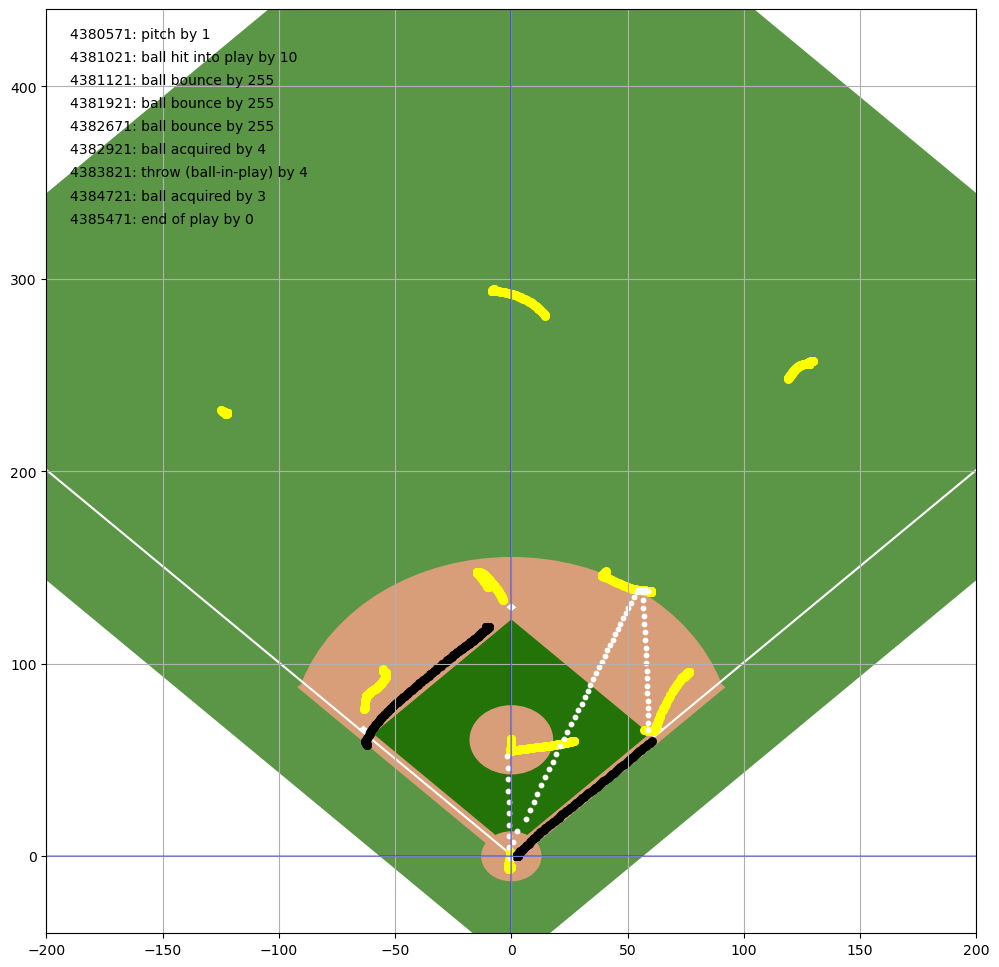

In [50]:
bf_1903_29.clear_plot()

play_id = bf_1903_29.game_obj.get_pid_from_ppg(130)

bf_1903_29.plot_all_components(play_id=play_id)
bf_1903_29.fig

#bf_1903_29.create_gif(play_id=play_id, tag="--deflection 1-5-3 safe")


In [45]:
game_info_1903_29.loc[game_info_1903_29["inning"] == 7]

,game_str,home_team,away_team,at_bat,play_per_game,inning,top_bottom_inning,pitcher,catcher,first_base,second_base,third_base,shortstop,left_field,center_field,right_field,batter,first_baserunner,second_baserunner,third_baserunner,n_br,prev_outs,this_play_outs,trust_this_play,Batter,Runner 1st,Runner 2nd,Runner 3rd,player_pos_and_info_agree,valid_half,trust_this_half
208,1903_29_TeamNF_TeamA2,TeamA2,TeamNF,50,212,7,Top,1519,1195,2526,1725,1972,1181,1751,1177,2837,4728,0,0,0,0,0,0,1,1,0,0,0,1,1,1
209,1903_29_TeamNF_TeamA2,TeamA2,TeamNF,50,213,7,Top,1519,1195,2526,1725,1972,1181,1751,1177,2837,4728,0,0,0,0,0,0,1,1,0,0,0,1,1,1
210,1903_29_TeamNF_TeamA2,TeamA2,TeamNF,50,214,7,Top,1519,1195,2526,1725,1972,1181,1751,1177,2837,4728,0,0,0,0,0,0,1,1,0,0,0,1,1,1
211,1903_29_TeamNF_TeamA2,TeamA2,TeamNF,50,215,7,Top,1519,1195,2526,1725,1972,1181,1751,1177,2837,4728,0,0,0,0,0,0,1,1,0,0,0,1,1,1
212,1903_29_TeamNF_TeamA2,TeamA2,TeamNF,50,216,7,Top,1519,1195,2526,1725,1972,1181,1751,1177,2837,4728,0,0,0,0,0,0,1,1,0,0,0,1,1,1
213,1903_29_TeamNF_TeamA2,TeamA2,TeamNF,50,217,7,Top,1519,1195,2526,1725,1972,1181,1751,1177,2837,4728,0,0,0,0,0,0,1,1,0,0,0,1,1,1
214,1903_29_TeamNF_TeamA2,TeamA2,TeamNF,50,218,7,Top,1519,1195,2526,1725,1972,1181,1751,1177,2837,4728,0,0,0,0,0,1,1,1,0,0,0,1,1,1
215,1903_29_TeamNF_TeamA2,TeamA2,TeamNF,51,219,7,Top,1519,1195,2526,1725,1972,1181,1751,1177,2837,5719,0,0,0,0,1,0,1,1,0,0,0,1,1,1
216,1903_29_TeamNF_TeamA2,TeamA2,TeamNF,52,220,7,Top,1519,1195,2526,1725,1972,1181,1751,1177,2837,9780,0,5719,0,1,1,0,1,1,0,1,0,1,1,1
217,1903_29_TeamNF_TeamA2,TeamA2,TeamNF,52,221,7,Top,1519,1195,2526,1725,1972,1181,1751,1177,2837,9780,0,5719,0,1,1,0,1,1,0,1,0,1,1,1


## Another spot check 1902_19_TeamME_TeamA2 is breaking my Game class rn

- This was breaking my loop, treat this one individually

In [ ]:
g_1902_19 = Game("1902_19_TeamME_TeamA2", debug_mode=True)

In [11]:
g_1902_19.game_events_df = g_1902_19._prep_events_df(g_1902_19.game_events_df)
g_1902_19.new_player_pos = g_1902_19._prep_player_pos_df(g_1902_19.player_pos_df)

# g_1902_19.game_info_df = g_1902_19._prep_info_df(g_1902_19.game_info_df)

# SOMETHING IS HANGING HERE!

# g_1902_19.impute_outs(g_1902_19.game_info_df, verbose=True)